In [3]:
# @title Setup packages
import pandas as pd
from collections import Counter
import random
#from google.colab import output
import json
import time
from bs4 import BeautifulSoup
import random
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import spacy


In [ ]:
# # magic needed to just let importing openAI work on colab
# %%writefile /usr/local/lib/python3.10/dist-packages/openai/_utils/_streams.py
# from typing import Any
# from typing_extensions import AsyncIterator
# from typing import Iterator # import Iterator from the correct library

# def consume_sync_iterator(iterator: Iterator[Any]) -> None:
#     for _ in iterator:
#         ...

# async def consume_async_iterator(iterator: AsyncIterator[Any]) -> None:
#     async for _ in iterator:
#         ...



In [4]:
from openai import OpenAI

In [5]:
nlp = spacy.load("en_core_web_trf")

sns.set(context="poster", style='white')
#output.clear()

In [6]:
df=pd.read_csv("cleaned_fakenewsdata.csv")
false_flags = ['REAL']
fake_news=df.query("label in @ false_flags")

In [7]:
# @title Get a list of election-related misinformation from PolitiFact.
# @markdown ToDos: Filter on date, Extract source of claim

def flatten_list_of_lists(list_of_lists):
    return [item for sublist in list_of_lists for item in sublist]

def scrape_election_claims(pg_no):
    """
    Scrapes election related claims and their truth values from Politifact

    Params
    - pg_no (int): Page number

    Returns
    - A list of tuples with each tuple containing a claim and its truth value
    """
    url = f"https://www.politifact.com/factchecks/list/?page={pg_no}&category=elections"
    print("Scraping page:", pg_no)
    print("URL:", url)

    time.sleep(random.random())
    claims_data = []
    response = requests.get(url)
    if response.status_code == 200:
        try:
            soup = BeautifulSoup(response.content, 'html.parser')
            claims = soup.find_all('div', class_='m-statement__quote')
            truth_values = soup.find_all('div', class_='m-statement__meter')

            for claim, truth_value in zip(claims, truth_values):
                claim_text = claim.get_text(strip=True)
                truth_value_text = truth_value.find('img').get('alt')  # Assuming the truth value is in an image alt text
                claims_data.append((claim_text, truth_value_text))
        except Exception as e:
            print(f"Retrieved page but couldn't parse claims for page {pg_no} due to {e}")
    else:
        print(f"Failed to retrieve the page. Status code: {response.status_code}")
    return claims_data



claims = [scrape_election_claims(pg_no=i) for i in range(1, 10)]
claims = flatten_list_of_lists(claims)
claim_df = pd.DataFrame(claims, columns=['claim', 'truth'])
false_flags = ['false', 'pants-fire']
claim_df = claim_df.query("truth in @ false_flags")
print(f"Number of claims scraped where truth value is in {' OR '.join([x for x in false_flags])}: ", len(claim_df))

Scraping page: 1
URL: https://www.politifact.com/factchecks/list/?page=1&category=elections
Scraping page: 2
URL: https://www.politifact.com/factchecks/list/?page=2&category=elections
Scraping page: 3
URL: https://www.politifact.com/factchecks/list/?page=3&category=elections
Scraping page: 4
URL: https://www.politifact.com/factchecks/list/?page=4&category=elections
Scraping page: 5
URL: https://www.politifact.com/factchecks/list/?page=5&category=elections
Scraping page: 6
URL: https://www.politifact.com/factchecks/list/?page=6&category=elections
Scraping page: 7
URL: https://www.politifact.com/factchecks/list/?page=7&category=elections
Scraping page: 8
URL: https://www.politifact.com/factchecks/list/?page=8&category=elections
Scraping page: 9
URL: https://www.politifact.com/factchecks/list/?page=9&category=elections
Number of claims scraped where truth value is in false OR pants-fire:  194


c:\Users\david\anaconda3\envs\openai\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\david\anaconda3\envs\openai\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


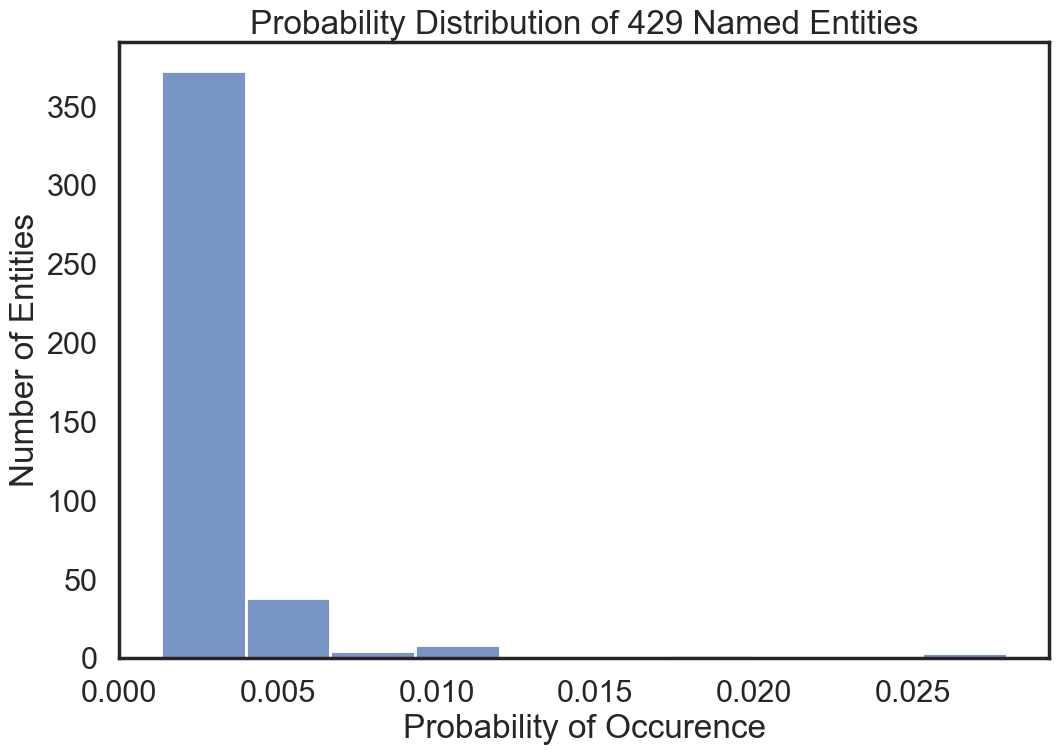

c:\Users\david\anaconda3\envs\openai\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\david\anaconda3\envs\openai\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\david\anaconda3\envs\openai\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Top 20 Named Entities')

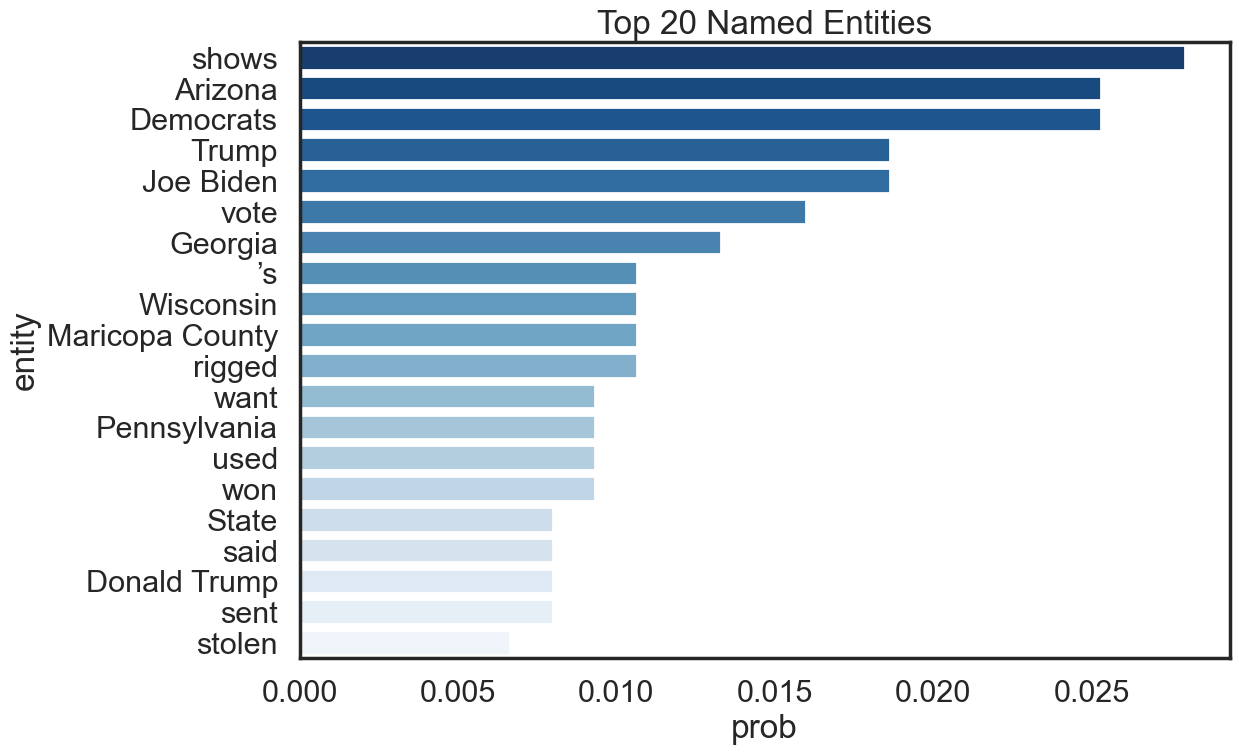

In [13]:
# @title Get named entities.
# @markdown It takes awhile using Spacy Transformers. ToDos:  (1) Better filter out non-useful named entities such as numbers and (2) filter out duplicates like "Biden" and "Joe Biden"
def extract_named_entities(nlp, text):
    doc = nlp(text)
    
    # Initialize an empty list to hold our "entities" (verb phrases and noun phrases) without stop words
    entities = []
    
    # Extract verb phrases without stop words
    for token in doc:
        if token.pos_ == "VERB":
            # Include the verb itself if it's not a stop word and its non-stop word children
            verb_phrase = token.text
            if len(verb_phrase) > 1:  # Ensure the phrase includes more than just the verb
                entities.append(verb_phrase)
                
    # Extract noun phrases without stop words
    for chunk in doc.ents:
        # Filter out stop words from the noun chunk
        filtered_phrase = " ".join(token.text for token in chunk if not token.is_stop)
        if filtered_phrase:  # If the filtered phrase is not empty
            entities.append(filtered_phrase)
    
    return entities
def refine_entities(entities):
    refined_entities = []
    seen = {}  # Use a dictionary to map lowercased entities to their original form

    # Remove entities containing numeric characters
    non_numeric_entities = [entity for entity in entities if not any(char.isdigit() for char in entity)]
    
    for entity in non_numeric_entities:
        lower_entity = entity.lower()

        # Check for partial matches
        partial_match_found = False
        for seen_entity in list(seen):
            if lower_entity in seen_entity or seen_entity in lower_entity:
                # Keep the longer name, ensure you're removing and adding the correct form
                if len(lower_entity) > len(seen_entity):
                    # Remove the original form of the seen entity from both 'seen' and 'refined_entities'
                    original_form = seen.pop(seen_entity)
                    refined_entities.remove(original_form)
                    # Add the new entity in its original form
                    seen[lower_entity] = entity
                    refined_entities.append(entity)
                partial_match_found = True
                break

        if not partial_match_found and lower_entity not in seen:
            seen[lower_entity] = entity  # Store with original casing
            refined_entities.append(entity)

    return refined_entities

def gen_entities(entity_probabilities, n=2):
  """
  Generate entities according to weights of occurence in dataset

  Params:
    entity_probabilities (dict): A dict like {entity: probability}

  Returns a list of `n` entities
  """
  return random.choices(list(entity_probabilities.keys()), weights=entity_probabilities.values(), k=n)

def gen_claims(claims, n=2):
  """Generate a random sample of claims"""
  return random.sample(list(claims), k=n)

entities_per_claim = [extract_named_entities(nlp, claim) for claim in claim_df['claim'].unique()]
refined_entities_list = []
for entities in entities_per_claim:
    refined_entities = refine_entities(entities)
    refined_entities_list.append(refined_entities)

# # Make distribution
entity_frequency = Counter([entity for sublist in refined_entities_list for entity in sublist])
total_entities = sum(entity_frequency.values())
entity_probabilities = {entity: freq / total_entities for entity, freq in entity_frequency.items()}

# Plot some entity distributions
prob_df = pd.DataFrame(entity_probabilities, index=[1]).T.reset_index()
prob_df.columns = ['entity', 'prob']
prob_df = prob_df.sort_values(by=['prob'], ascending=False)

plt.figure(figsize=(12,8))
sns.histplot(prob_df['prob'])
plt.title(f"Probability Distribution of {prob_df['entity'].nunique()} Named Entities")
plt.ylabel("Number of Entities")
plt.xlabel("Probability of Occurence")
plt.show()

plt.figure(figsize=(12,8))
sns.barplot(data=prob_df.head(20), x='prob', y='entity', palette='Blues_r')
plt.title("Top 20 Named Entities")



c:\Users\david\anaconda3\envs\openai\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\david\anaconda3\envs\openai\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


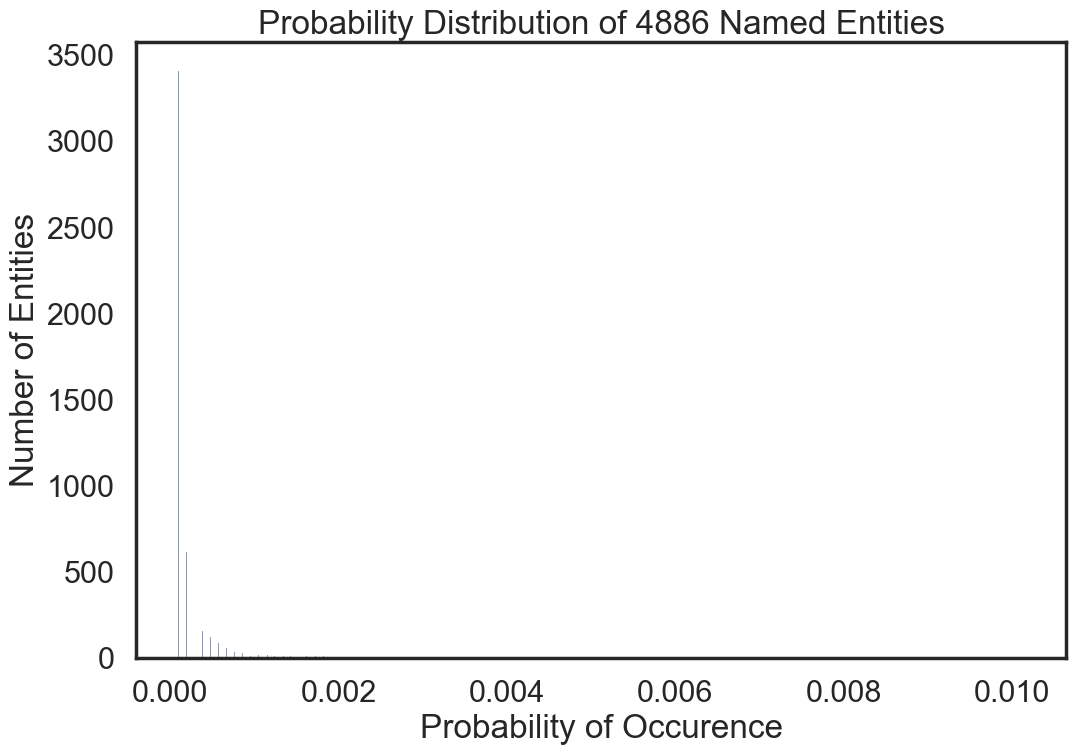

c:\Users\david\anaconda3\envs\openai\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\david\anaconda3\envs\openai\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\david\anaconda3\envs\openai\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Top 20 Named Entities')

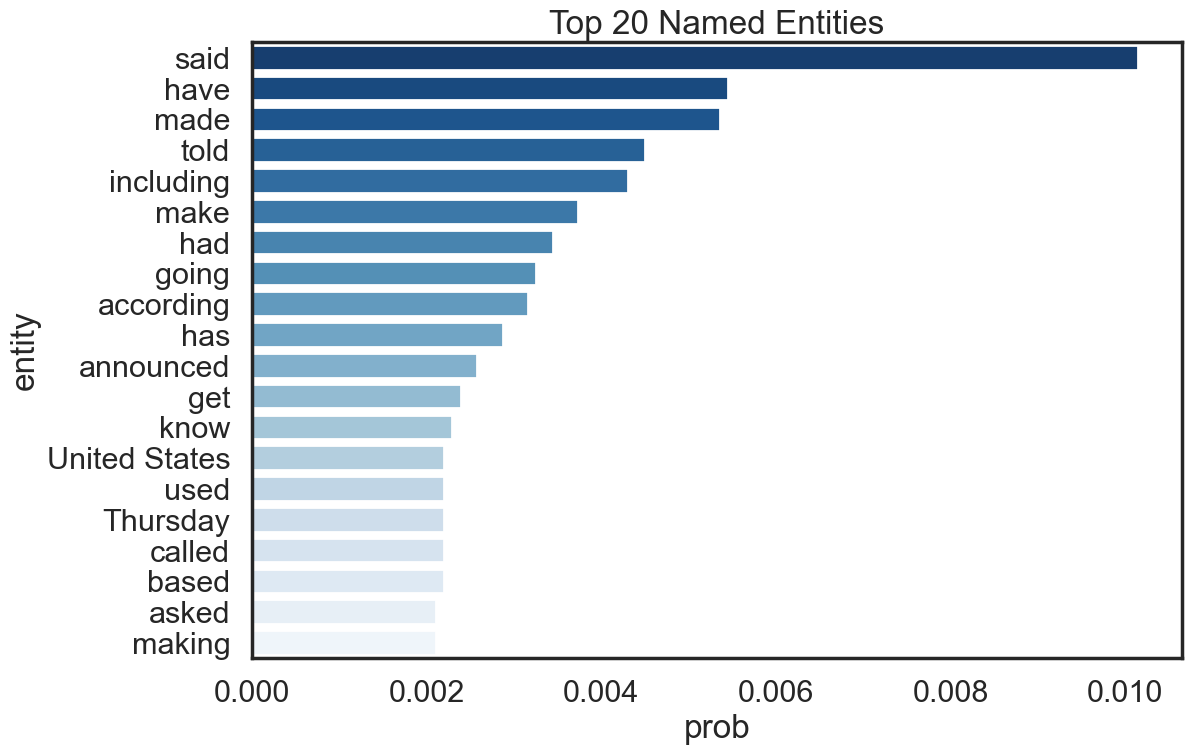

In [14]:
fake_news_sample=fake_news.sample(frac=0.03, replace=True, random_state=1)
# Get named entities
fn_entities_per_claim = [extract_named_entities(nlp, claim) for claim in fake_news_sample['text'].unique()]
fn_refined_entities_list = []
for fn_entities in fn_entities_per_claim:
    fn_refined_entities = refine_entities(fn_entities)
    fn_refined_entities_list.append(fn_refined_entities)

# # Make distribution
fn_entity_frequency = Counter([entity for sublist in fn_refined_entities_list for entity in sublist])
fn_total_entities = sum(fn_entity_frequency.values())
fn_entity_probabilities = {entity: freq / fn_total_entities for entity, freq in fn_entity_frequency.items()}

# Plot some entity distributions
fn_prob_df = pd.DataFrame(fn_entity_probabilities, index=[1]).T.reset_index()
fn_prob_df.columns = ['entity', 'prob']
fn_prob_df = fn_prob_df.sort_values(by=['prob'], ascending=False)

plt.figure(figsize=(12,8))
sns.histplot(fn_prob_df['prob'])
plt.title(f"Probability Distribution of {fn_prob_df['entity'].nunique()} Named Entities")
plt.ylabel("Number of Entities")
plt.xlabel("Probability of Occurence")
plt.show()

plt.figure(figsize=(12,8))
sns.barplot(data=fn_prob_df.head(20), x='prob', y='entity', palette='Blues_r')
plt.title("Top 20 Named Entities")

# Generate similar misinformation using a few-shot prompt.

- CONTEXT: We provide `N_EXAMPLES` of claims and `N_EXAMPLES` of named entities, where the probability of a named entity being picked is proportional to its probability in the dataset

- PROMPT: Ask ChatGPT to generate `N_STATEMENTS` similar to the example claims, where each claim is about at least one of the named entities.

- CONSTRAINTS: By default we say `Each statement should sound very realistic.` but can experiment by tweaking `MORE_INSTRUCTIONS`

Possible ToDos: Prompt experiments, change hyperparameters, add source, source-entity co-occurence, fine-tuning


In [12]:
# @title Prompt Generator { vertical-output: true }
N_STATEMENTS = 10# @param {type:"slider", min:1, max:10, step:1}
N_EXAMPLES =  10# @param {type:"slider", min:1, max:10, step:1}
MODEL = "gpt-3.5-turbo" # @param ["gpt-3.5-turbo", "gpt-4"]
MORE_INSTRUCTIONS = "" # @param {type:"string"}
OPENAI_KEY = "" # @param {type:"string"}

def query_openai(prompt, model):
  """Query openai"""
  client = OpenAI(api_key=OPENAI_KEY)
  response = client.chat.completions.create(
    model=model,
    messages=[
      {
        "role": "user",
        "content": prompt
      },
    ],
    temperature=1,
    max_tokens=256,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0
  )
  return json.loads(response.json())['choices'][0]['message']['content']


def get_prompt(entity_probabilities, claims, n_statements=1, n_examples=2, more_instructions=""):
  """
  Build a prompt for few shot misinfo generation

  Params
  - entity_probabilities (dict): {entity, prob} dictionary
  - claims (list): A list of claims
  - n_statements(int, default=1): Number of statements to generate
  - n_examples (int, default=2): Number of examples
  - more_instructions (str, default=''): A string of addtnl instructions

  Returns:
    A string of a ChatGPT prompt

  """
  claims = '-' + " \n-".join([x for x in set(gen_claims(claims, n=n_examples))])
  entities = '-' + " \n-".join([x for x in  set(gen_entities(entity_probabilities, n=n_examples))])

  prompt = f"""Generate {n_statements} statement(s) similar to these statements: \n{claims}\n\nEach statement should be about at least one of these entities:\n{entities}\n\nReturn a newline-seperated list of statements and nothing else.\n\nSTATEMENTS:\n-Statement1 \n-Statement2\n...\nCONSTRAINTS:\n-Each statement should sound very realistic.\n{'-' + more_instructions if more_instructions else ''}\n\n"""
  return entities, prompt

extracted_entities, prompt = get_prompt(entity_probabilities, fake_news['text'].values, n_statements=N_STATEMENTS, n_examples=N_EXAMPLES, more_instructions=MORE_INSTRUCTIONS)
print("PROMPT:\n\n", prompt)

response = query_openai(prompt, MODEL)
print("RESPONSE:\n\n", response)

PROMPT:

 Generate 10 statement(s) similar to these statements: 
-It’s 50 yrs since the US-backed coup against Chile’s socialist president, Salvador Allende. Farrah Koutteineh reflects on the splits among the country's Palestinians over the Pinochet dictatorship that set in & how it impacted Palestine liberation. The Palestinian community in Chile, which is the largest outside the Middle East with over half a million living in the coastal Latin American country, are a divided collective, writes Farrah Koutteineh. [GETTY] This week marks 50 years since the US backed military coup against democratically elected Chilean President, Salvador Allende. A coup which led to over 17 years of bloody dictatorship by Augusto Pinochet, who reversed all of Allende’s socialist policies, turned football stadiums into concentration camps overnight, and who oversaw the forced disappearances and murder of thousands of Chileans he and his forces deemed to be left wing. 
-'My voice is so comforting': New Yo

APIConnectionError: Connection error.

In [56]:
f = open('text.txt')
response=f.read()
response

"-ATLANTA, Ga. (WABE) - In a recent address, Georgia Governor Brian Kemp criticized the Biden administration's policies, claiming they undermine state efforts to improve education and economic development. Kemp, a Republican, highlighted his administration's achievements in job creation and education reform, contrasting them with what he perceives as federal overreach. He also took a moment to acknowledge the state's progress in handling the COVID-19 pandemic, emphasizing the importance of state-led initiatives over federal mandates.\n-HARRISBURG, Pa. (WITF) - During a press conference, Pennsylvania's GOP leaders unveiled a new legislative agenda focused on election integrity, with specific emphasis on strengthening voter ID laws. The announcement follows ongoing debates about election security, with GOP officials arguing that their measures are essential for maintaining public trust in electoral processes. Critics, however, contend that these efforts may suppress voter turnout, partic

In [57]:
# List of all GPT-generated statments
statements_list = response.strip().split('\n')
statements_list = [statement.lstrip('-') for statement in statements_list]
statements_list

["ATLANTA, Ga. (WABE) - In a recent address, Georgia Governor Brian Kemp criticized the Biden administration's policies, claiming they undermine state efforts to improve education and economic development. Kemp, a Republican, highlighted his administration's achievements in job creation and education reform, contrasting them with what he perceives as federal overreach. He also took a moment to acknowledge the state's progress in handling the COVID-19 pandemic, emphasizing the importance of state-led initiatives over federal mandates.",
 "HARRISBURG, Pa. (WITF) - During a press conference, Pennsylvania's GOP leaders unveiled a new legislative agenda focused on election integrity, with specific emphasis on strengthening voter ID laws. The announcement follows ongoing debates about election security, with GOP officials arguing that their measures are essential for maintaining public trust in electoral processes. Critics, however, contend that these efforts may suppress voter turnout, part

In [58]:
statements_list

["ATLANTA, Ga. (WABE) - In a recent address, Georgia Governor Brian Kemp criticized the Biden administration's policies, claiming they undermine state efforts to improve education and economic development. Kemp, a Republican, highlighted his administration's achievements in job creation and education reform, contrasting them with what he perceives as federal overreach. He also took a moment to acknowledge the state's progress in handling the COVID-19 pandemic, emphasizing the importance of state-led initiatives over federal mandates.",
 "HARRISBURG, Pa. (WITF) - During a press conference, Pennsylvania's GOP leaders unveiled a new legislative agenda focused on election integrity, with specific emphasis on strengthening voter ID laws. The announcement follows ongoing debates about election security, with GOP officials arguing that their measures are essential for maintaining public trust in electoral processes. Critics, however, contend that these efforts may suppress voter turnout, part

In [59]:
# List of all entities used to generated all the statements
extracted_entities_list = extracted_entities.strip().split('\n')
extracted_entities_list = [extracted_entities_list.lstrip('-') for extracted_entities_list in extracted_entities_list]
extracted_entities_list = [extracted_entities_list.rstrip() for extracted_entities_list in extracted_entities_list]

In [14]:
# Link all the entities with the statements and form a list
entities_in_statements = []
for statement in statements_list:
    entities_in_current_statement = [entity for entity in extracted_entities_list if entity.lower() in statement.lower()]
    entities_in_statements.append(entities_in_current_statement)

In [15]:
entities_in_statements

[['GOP', 'Abraham Lincoln'],
 ['Democrats', 'Nevada', 'Congress'],
 ['Trump', 'Pennsylvania Senate'],
 ['Zero', 'Biden'],
 ['GOP'],
 ['Waffle House'],
 ['GOP', 'Democrats'],
 ['Biden'],
 ['Nevada'],
 ['Congress']]

In [24]:
for i in range(len(entities_in_statements)):
    for j in range(len(entities_in_statements[i])):
        statements_list[i]=statements_list[i].replace(entities_in_statements[i][j],'')
        statements_list[i]=statements_list[i].replace("  ",' ')
        statements_list[i]=statements_list[i].strip()
candidates=statements_list  

In [21]:
# Search out all the rows that had any of the entities that the each of the generated statements used
filtered_rows=[]
for entities_per_statement in entities_in_statements:
    filtered_rows_per_statement = [index for index, row in enumerate(entities_per_claim) if any(element in entities_per_statement for element in row)]
    filtered_rows.append(filtered_rows_per_statement)

In [22]:
references=[]
claim_df.reset_index()
for row_list in filtered_rows:
    references_per_statement=[]
    for row_num in row_list:
        references_per_statement.append(claim_df.iloc[row_num]["claim"])
    references.append(references_per_statement)
references

[['"Last time Democrats removed a Republican from the ballot” was Abraham Lincoln in 1860.',
  'GOP-authored elections bill “requires valid votes to be tossed out … if a computer rejects a signature.”',
  'Bags arriving at the Maricopa County vote counting site are evidence of “Democrats with the help of the media and GOP establishment stealing another election.”',
  'Video shows a faulty New York voting machine invalidated a GOP vote in governor’s race.',
  'Video suggests GOP voters denied access in general election.'],
 ['Taylor Swift was photographed holding a “Trump won, Democrats cheated!” flag at the Grammy Awards.',
  '"Last time Democrats removed a Republican from the ballot” was Abraham Lincoln in 1860.',
  'Taylor Swift was photographed holding a “Trump won, Democrats cheated!” flag.',
  'Democrats “used COVID to cheat” in the 2020 election.',
  'Says President Joe Biden said that Democrats should not vote in the New Hampshire primary.',
  'Democrats have also used alternate

In [23]:
references=[]
claim_df.reset_index()
for i in range(len(filtered_rows)):
    row_list=filtered_rows[i]
    references_per_statement=[]
    for row_num in row_list:
        current_row=claim_df.iloc[row_num]["claim"]
        for j in range(len(entities_in_statements[i])):
            current_row=current_row.replace(entities_in_statements[i][j],'')
            current_row=current_row.replace("  ",' ')
            current_row=current_row.strip()
        references_per_statement.append(current_row)
    references.append(references_per_statement)
references

[['"Last time Democrats removed a Republican from the ballot” was in 1860.',
  '-authored elections bill “requires valid votes to be tossed out … if a computer rejects a signature.”',
  'Bags arriving at the Maricopa County vote counting site are evidence of “Democrats with the help of the media and establishment stealing another election.”',
  'Video shows a faulty New York voting machine invalidated a vote in governor’s race.',
  'Video suggests voters denied access in general election.'],
 ['Taylor Swift was photographed holding a “Trump won, cheated!” flag at the Grammy Awards.',
  '"Last time removed a Republican from the ballot” was Abraham Lincoln in 1860.',
  'Taylor Swift was photographed holding a “Trump won, cheated!” flag.',
  '“used COVID to cheat” in the 2020 election.',
  'Says President Joe Biden said that should not vote in the New Hampshire primary.',
  'have also used alternate slates of electors "repeatedly in all kinds of different states."',
  'Vice President Mike

In [30]:
from bert_score import score
import numpy as np
import statistics

# Initialize an array to store the best F1 score for each candidate
best_f1_scores = np.zeros(len(candidates))
mean_f1_scores = np.zeros(len(candidates))
all_f1_scores= []
import warnings
warnings.filterwarnings('ignore')
# Compare each candidate against every reference
for i, candidate in enumerate(candidates):
    reference_list=references[i]
    # Store F1 scores for the current candidate against all references
    f1_scores_for_candidate = []
    
    for reference in reference_list:
        P, R, F1 = score([candidate], [reference], lang='en', verbose=False)
        f1_scores_for_candidate.append(F1.item())
    
    # Find the best F1 score for the current candidate
    best_f1_scores[i] = max(f1_scores_for_candidate)
    mean_f1_scores[i] = statistics.mean(f1_scores_for_candidate)
    all_f1_scores.append(f1_scores_for_candidate)

print(best_f1_scores)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

[0.8636986  0.86535454 0.86169362 0.86311877 0.87688476 0.84227318
 0.89003748 0.86993736 0.87032735 0.85155833]


In [29]:
mean_f1_scores

[0.8515583276748657]

In [31]:
all_f1_scores

[[0.8440982103347778,
  0.8506907224655151,
  0.8484954833984375,
  0.8610228896141052,
  0.8636986017227173],
 [0.8431341052055359,
  0.8343426585197449,
  0.8411144614219666,
  0.8551771640777588,
  0.8545246124267578,
  0.8288499712944031,
  0.8451351523399353,
  0.8346866369247437,
  0.8520903587341309,
  0.8545985817909241,
  0.8482168912887573,
  0.8516815304756165,
  0.8489385843276978,
  0.8653545379638672,
  0.8357235789299011,
  0.8452978730201721,
  0.8386783599853516,
  0.853184700012207,
  0.855168879032135,
  0.8354585766792297,
  0.8350589275360107],
 [0.8413650393486023,
  0.8385104537010193,
  0.8198007941246033,
  0.8375727534294128,
  0.8169186115264893,
  0.830079972743988,
  0.8332598805427551,
  0.8616936206817627,
  0.8518106937408447,
  0.836534857749939,
  0.8429849743843079,
  0.8403837084770203,
  0.829180896282196,
  0.8423041701316833,
  0.8322709202766418],
 [0.8459774851799011,
  0.8542119264602661,
  0.8540078997612,
  0.8631187677383423,
  0.82962673902

In [2]:
from nltk.translate.bleu_score import sentence_bleu
reference_sentence = "I am the walrus .".split()
candidate_sentence = "I am the walrus .".split()
bleu = sentence_bleu(reference_sentence, candidate_sentence)
print(f"BLEU score: {bleu:.4f}")


BLEU score: 0.0000


In [3]:
reference = [
    'this is a dog'.split(),
    'it is dog'.split(),
    'dog it is'.split(),
    'a dog, it is'.split() 
]
candidate = 'it is dog'.split()
print('BLEU score -> {}'.format(sentence_bleu(reference, candidate)))

BLEU score -> 1.2213386697554703e-77


In [5]:
reference = [['this', 'is', 'ae', 'test','rest','pep','did']]
candidate = ['this', 'is', 'ad', 'test','rest','pep','did']

sentence_bleu(reference, candidate)

0.488923022434901

In [2]:
#junk
import torch
if torch.cuda.is_available():
    print("CUDA is available. GPU will be used for computation.")
    device = torch.device("cuda")
else:
    print("CUDA is not available. Computation will fall back on the CPU.")
    device = torch.device("cpu")


CUDA is available. GPU will be used for computation.


In [ ]:
#junk for now
def Calc_Bert_Score(repeats=5):
    for i in range(repeats): 
        extracted_entities, prompt = get_prompt(fn_entity_probabilities, claim_df['claim'].values, n_statements=N_STATEMENTS, n_examples=N_EXAMPLES, more_instructions=MORE_INSTRUCTIONS)
        response = query_openai(prompt, MODEL)
        statements_list = response.strip().split('\n')
        statements_list = [statement.lstrip('-') for statement in statements_list]
        extracted_entities_list = extracted_entities.strip().split('\n')
        extracted_entities_list = [extracted_entities_list.lstrip('-') for extracted_entities_list in extracted_entities_list]
        extracted_entities_list = [extracted_entities_list.rstrip() for extracted_entities_list in extracted_entities_list]
        filtered_rows = [index for index, row in enumerate(entities_per_claim) if any(element in extracted_entities_list for element in row)]
        references=[]
        for row_num in filtered_rows:
            references.append(claims[row_num][0])
        candidates=statements_list

    